## 1) Load dataset

In [1]:
# Read the dataset into a pandas DataFrame
import pandas as pd
import os

# Update this path if needed (using raw strings to handle backslashes correctly)
if os.path.exists(r'/content/student-por.csv'):
    df = pd.read_csv(r'/content/student-por.csv', sep=';')
elif os.path.exists(r'/content/student-mat.csv'):
    df = pd.read_csv(r'/content/student-mat.csv', sep=';')
else:
    # Try to find any csv in working dir
    csvs = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
    if csvs:
        df = pd.read_csv(csvs[0], sep=';')
    else:
        df = pd.DataFrame()
        print('No CSV found in working directory. Please upload or set the correct path.')

print('Data shape:', df.shape)
df.head()

Data shape: (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## 2) Exploratory Data Analysis (EDA)
Inspect distributions, missing values, correlations, and class balance.


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    

None


--- Descriptive Statistics (numeric) ---


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000



--- Missing Values ---
No missing values found!

Plotting distributions for 16 numeric features...


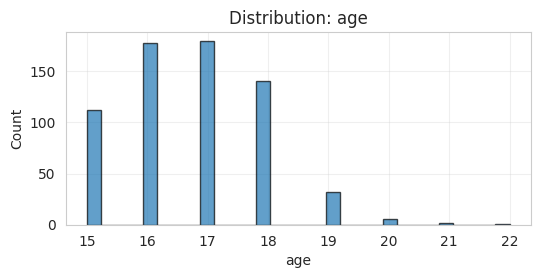

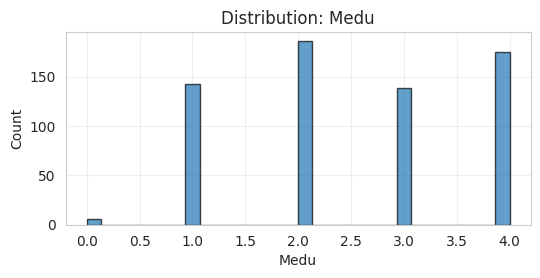

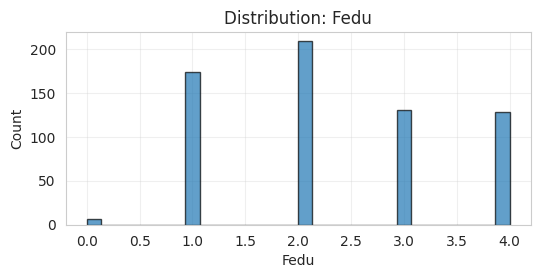

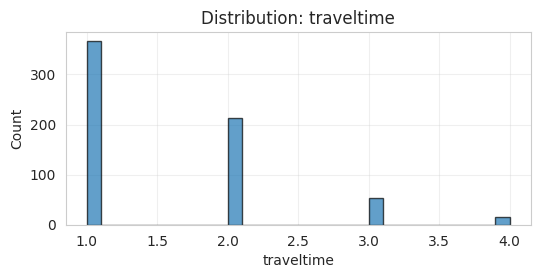

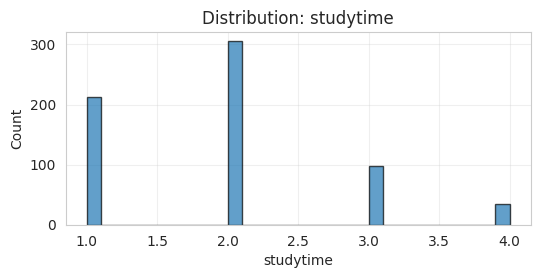

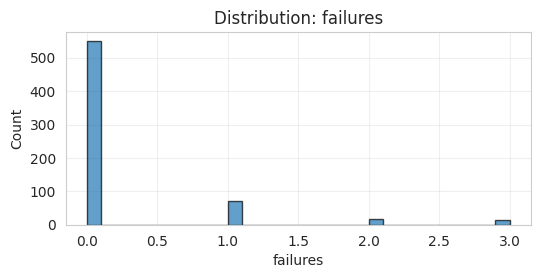

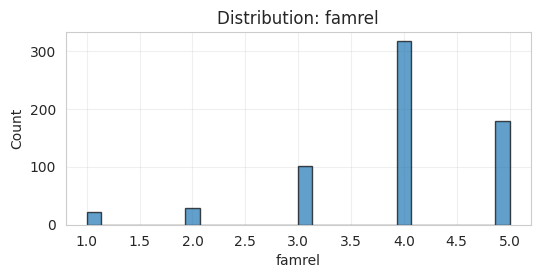

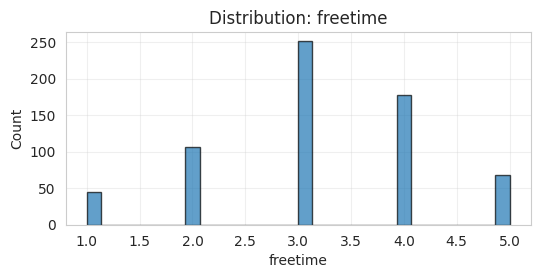

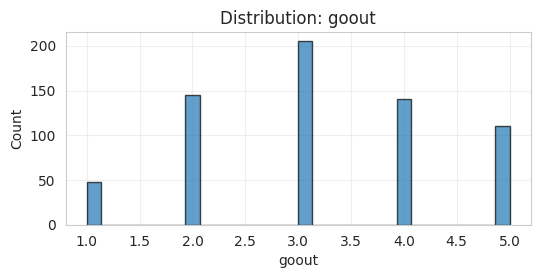

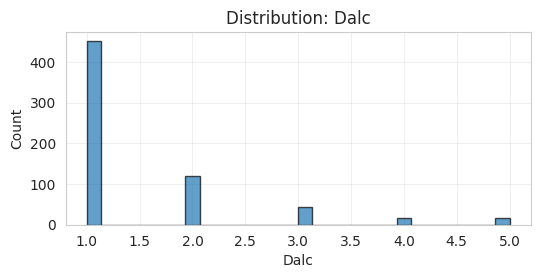

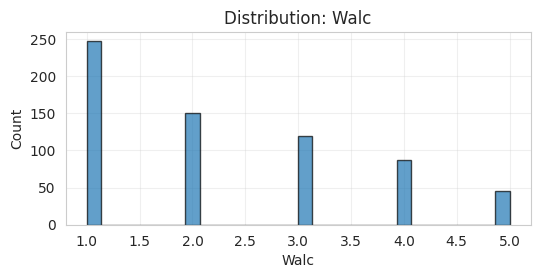

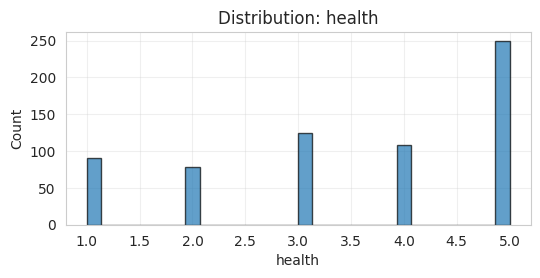

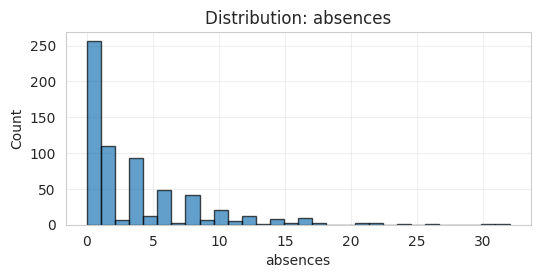

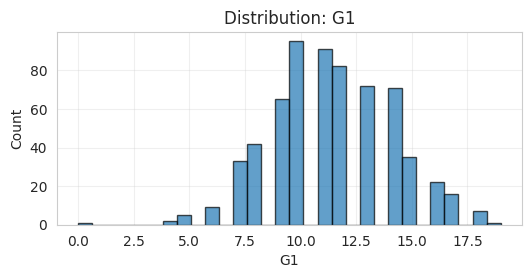

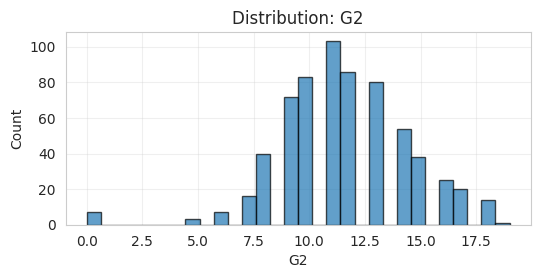


Plotting value counts for 6 categorical features...


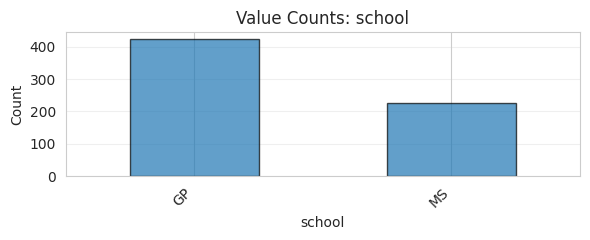

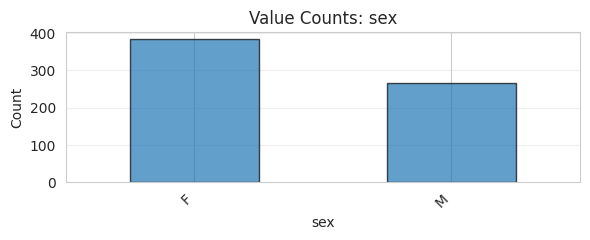

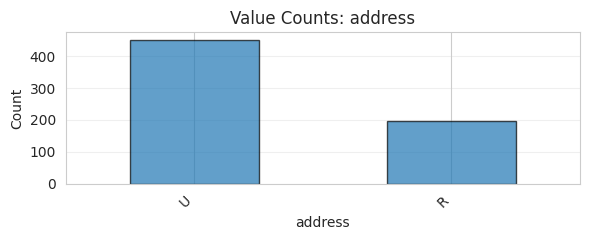

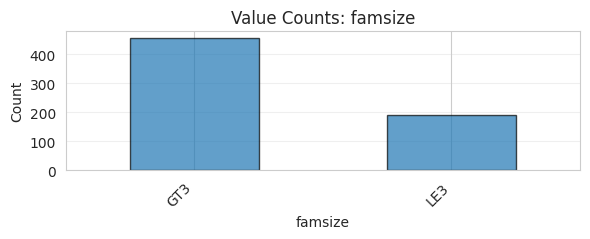

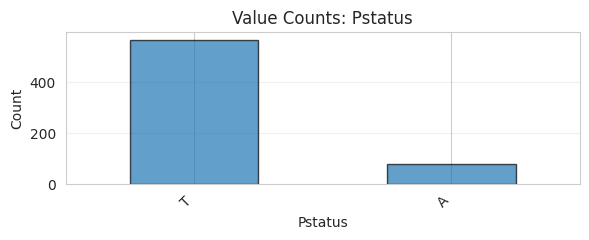

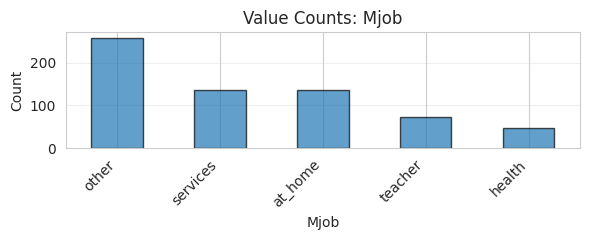

In [2]:
# Basic EDA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print('\n--- Dataset Info ---')
display(df.info())

print('\n--- Descriptive Statistics (numeric) ---')
display(df.describe())

print('\n--- Missing Values ---')
missing = df.isnull().sum()
if missing.sum() > 0:
    display(missing[missing > 0])
else:
    print('No missing values found!')

# Plot distributions for numeric features (one chart per numeric column)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f'\nPlotting distributions for {len(num_cols)} numeric features...')
for col in num_cols[:15]:  # Limit to first 15 to avoid too many plots
    plt.figure(figsize=(6,2.5))
    plt.hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot categorical value counts for top categorical columns
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print(f'\nPlotting value counts for {min(len(cat_cols), 6)} categorical features...')
for col in cat_cols[:6]:
    plt.figure(figsize=(6,2.5))
    df[col].value_counts().plot(kind='bar', edgecolor='black', alpha=0.7)
    plt.title(f'Value Counts: {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

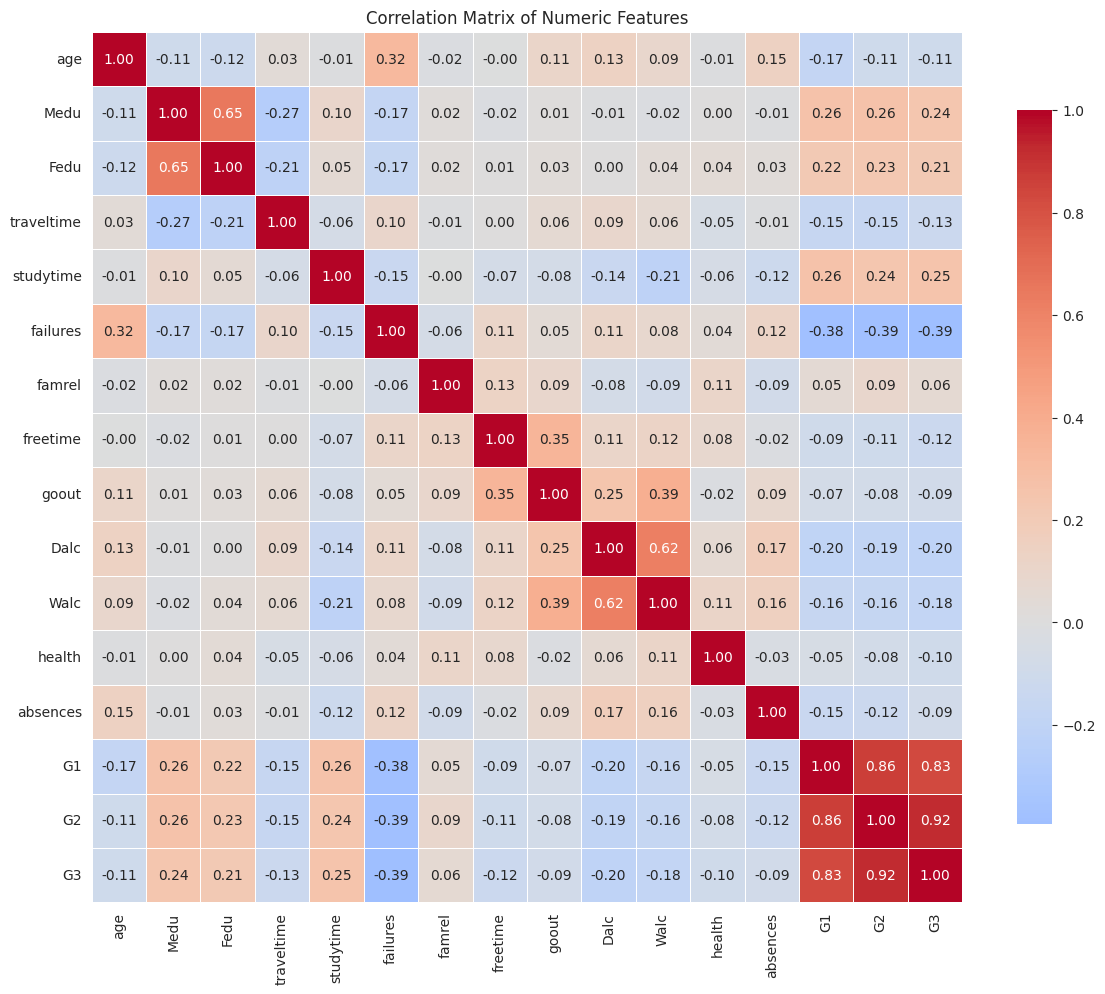


Features most correlated with Final Grade (G3):
G3            1.000000
G2            0.918548
G1            0.826387
studytime     0.249789
Medu          0.240151
Fedu          0.211800
famrel        0.063361
goout        -0.087641
absences     -0.091379
health       -0.098851
age          -0.106505
freetime     -0.122705
traveltime   -0.127173
Walc         -0.176619
Dalc         -0.204719
failures     -0.393316


In [3]:
# Correlation analysis for numeric features
numeric_df = df.select_dtypes(include=[np.number])
if len(numeric_df.columns) > 1:
    plt.figure(figsize=(12, 10))
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Numeric Features')
    plt.tight_layout()
    plt.show()

    # Show features most correlated with G3 (final grade)
    if 'G3' in correlation_matrix.columns:
        print('\nFeatures most correlated with Final Grade (G3):')
        g3_corr = correlation_matrix['G3'].sort_values(ascending=False)
        print(g3_corr.to_string())
else:
    print('Not enough numeric columns for correlation analysis.')


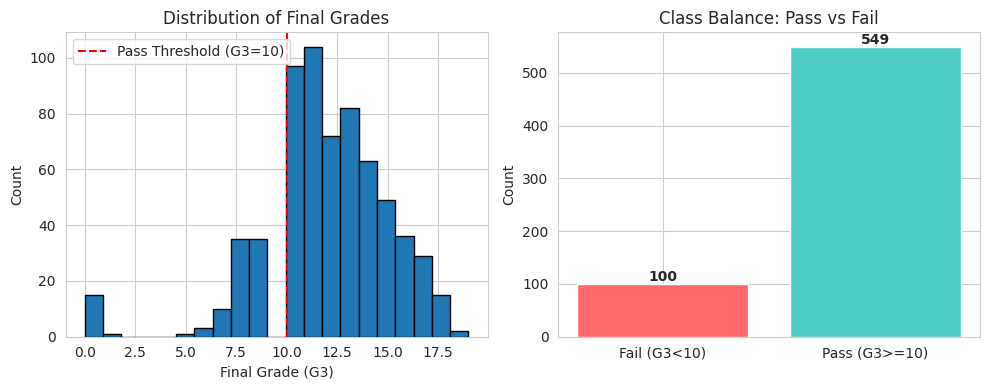

Pass rate: 549/649 = 84.6%
Fail rate: 100/649 = 15.4%


In [4]:
# Check class balance for target variable (G3 grades)
if 'G3' in df.columns:
    # Show distribution of final grades
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.hist(df['G3'], bins=21, edgecolor='black')
    plt.xlabel('Final Grade (G3)')
    plt.ylabel('Count')
    plt.title('Distribution of Final Grades')
    plt.axvline(x=10, color='r', linestyle='--', label='Pass Threshold (G3=10)')
    plt.legend()

    plt.subplot(1, 2, 2)
    pass_count = (df['G3'] >= 10).sum()
    fail_count = (df['G3'] < 10).sum()
    plt.bar(['Fail (G3<10)', 'Pass (G3>=10)'], [fail_count, pass_count], color=['#ff6b6b', '#4ecdc4'])
    plt.ylabel('Count')
    plt.title('Class Balance: Pass vs Fail')
    for i, v in enumerate([fail_count, pass_count]):
        plt.text(i, v + 5, str(v), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f'Pass rate: {pass_count}/{len(df)} = {pass_count/len(df)*100:.1f}%')
    print(f'Fail rate: {fail_count}/{len(df)} = {fail_count/len(df)*100:.1f}%')


## 3) Data Cleaning & Preprocessing
Handle missing values, encode categorical variables, and create target variable.

**Example target:** predict final grade pass/fail (G3 >= 10 -> pass). Adjust to your project's objective.

In [5]:
# Example preprocessing pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# Make a copy
data = df.copy()

# Example: create binary target 'pass' from final grade column G3 if present
if 'G3' in data.columns:
    data['pass'] = (data['G3'] >= 10).astype(int)
    target_col = 'pass'
else:
    # If no numeric grade present, user should set target manually
    print('No G3 column found. Please define your target_col manually.')
    target_col = None

# Drop columns unlikely to be helpful (example: drop G1 and G2 to avoid leakage)
# G1 and G2 are period grades that directly predict G3, so excluding them makes the problem more realistic
drop_cols = ['G1', 'G2']
for c in drop_cols:
    if c in data.columns:
        data.drop(columns=c, inplace=True)

# Separate features and target
if target_col:
    X = data.drop(columns=[target_col])
    y = data[target_col]
else:
    X = data.copy()
    y = None

# Simple handling: numeric columns fillna with median, categorical with mode, one-hot encode categoricals
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preproc = ColumnTransformer([('num', num_pipe, num_cols),
                             ('cat', cat_pipe, cat_cols)], remainder='drop')

# Note: For supervised learning, preproc will be fit on training data only (see Cell 11)
# For unsupervised learning (clustering), we'll fit on the full dataset
print('Feature columns identified:')
print(f'  - Numeric: {len(num_cols)} columns')
print(f'  - Categorical: {len(cat_cols)} columns')

Feature columns identified:
  - Numeric: 14 columns
  - Categorical: 17 columns


In [6]:
# Extract column names after OneHotEncoder for interpretability
# Fit preproc on full X temporarily just to get feature names
try:
    preproc_temp = ColumnTransformer([('num', num_pipe, num_cols),
                                      ('cat', cat_pipe, cat_cols)], remainder='drop')
    preproc_temp.fit(X)

    ohe = None
    for name, trans, cols in preproc_temp.transformers_:
        if name == 'cat':
            ohe = trans.named_steps['onehot']
            cat_in_cols = cols
    feature_names = []
    # numeric names
    feature_names.extend(num_cols)
    # onehot names
    if ohe is not None:
        ohe_names = ohe.get_feature_names_out(cat_in_cols)
        feature_names.extend(list(ohe_names))
    print('Number of features after preprocessing:', len(feature_names))
except Exception as e:
    feature_names = None
    print('Could not extract feature names automatically.', e)

feature_names[:50] if feature_names else None

Number of features after preprocessing: 57


['age',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences',
 'G3',
 'school_GP',
 'school_MS',
 'sex_F',
 'sex_M',
 'address_R',
 'address_U',
 'famsize_GT3',
 'famsize_LE3',
 'Pstatus_A',
 'Pstatus_T',
 'Mjob_at_home',
 'Mjob_health',
 'Mjob_other',
 'Mjob_services',
 'Mjob_teacher',
 'Fjob_at_home',
 'Fjob_health',
 'Fjob_other',
 'Fjob_services',
 'Fjob_teacher',
 'reason_course',
 'reason_home',
 'reason_other',
 'reason_reputation',
 'guardian_father',
 'guardian_mother',
 'guardian_other',
 'schoolsup_no',
 'schoolsup_yes',
 'famsup_no',
 'famsup_yes',
 'paid_no',
 'paid_yes',
 'activities_no',
 'activities_yes',
 'nursery_no']

## 4) Predictive Modeling (Supervised)
Three models: Logistic Regression, Random Forest, and Gradient Boosting.

In [7]:
# Modeling: train/test split and basic training pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Only proceed if we have a target
if y is None:
    print('No target variable defined. Define y to proceed with supervised modeling.')
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    # Fit preprocessor ONLY on training data to avoid data leakage
    X_train_pre = preproc.fit_transform(X_train)
    X_test_pre = preproc.transform(X_test)

    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42)
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train_pre, y_train)
        y_pred = model.predict(X_test_pre)
        y_proba = model.predict_proba(X_test_pre)[:,1] if hasattr(model, 'predict_proba') else None
        res = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
        }
        if y_proba is not None:
            res['roc_auc'] = roc_auc_score(y_test, y_proba)
        results[name] = res
        print(f'--- {name} ---')
        print(classification_report(y_test, y_pred))
    print('\nSummary results:')
    import pandas as pd
    display(pd.DataFrame(results).T)

--- LogisticRegression ---
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.97      1.00      0.99       110

    accuracy                           0.98       130
   macro avg       0.99      0.93      0.95       130
weighted avg       0.98      0.98      0.98       130

--- RandomForest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00       110

    accuracy                           1.00       130
   macro avg       1.00      1.00      1.00       130
weighted avg       1.00      1.00      1.00       130

--- GradientBoosting ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00       110

    accuracy                           1.00       130
   macro avg       1.00      1.00      1.00       130
w

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.976923,0.973451,1.0,0.986547,1.0
RandomForest,1.000000,1.000000,1.0,1.000000,1.0
GradientBoosting,1.000000,1.000000,1.0,1.000000,1.0


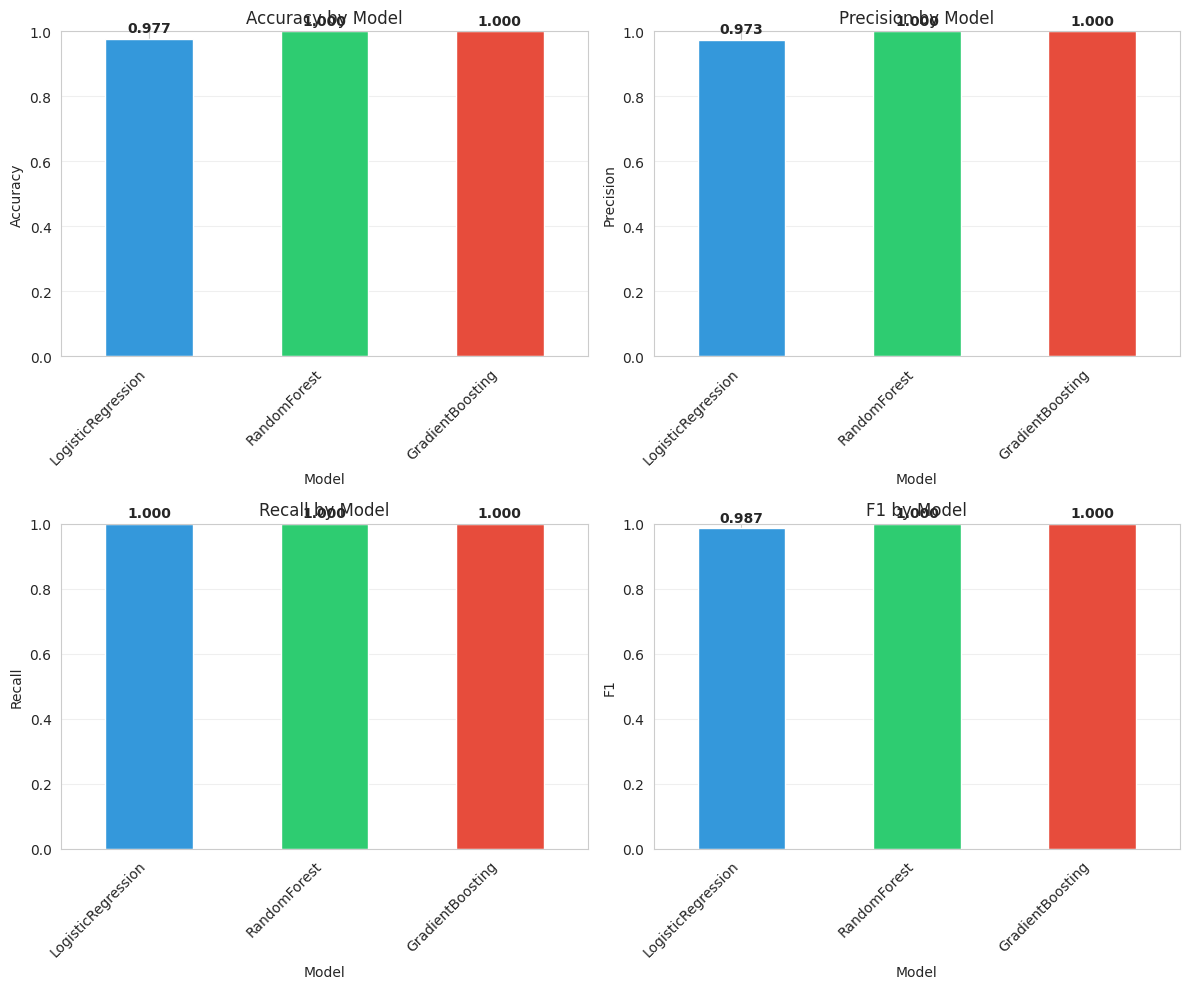

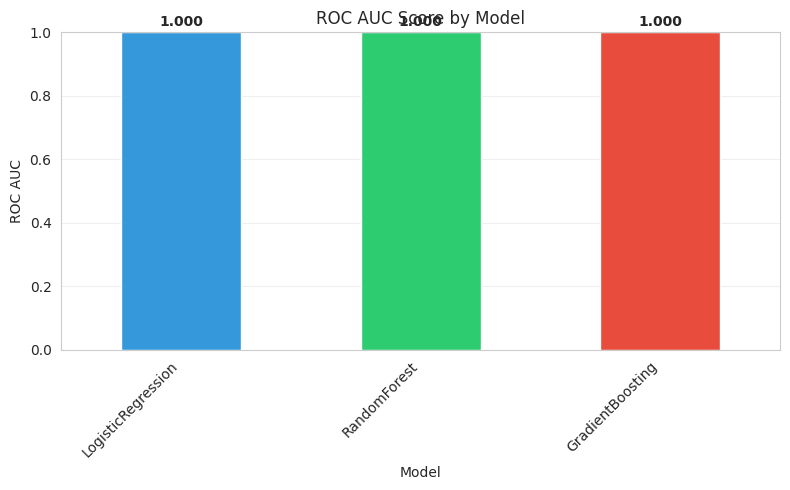

In [8]:
# Visualize model performance comparison
if y is not None and len(results) > 0:
    import pandas as pd
    results_df = pd.DataFrame(results).T

    # Plot metrics comparison
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        if metric in results_df.columns:
            results_df[metric].plot(kind='bar', ax=ax, color=['#3498db', '#2ecc71', '#e74c3c'])
            ax.set_title(f'{metric.capitalize()} by Model')
            ax.set_ylabel(metric.capitalize())
            ax.set_xlabel('Model')
            ax.set_ylim([0, 1])
            ax.grid(True, alpha=0.3, axis='y')
            ax.set_xticklabels(results_df.index, rotation=45, ha='right')

            # Add value labels on bars
            for i, v in enumerate(results_df[metric]):
                ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Display ROC AUC comparison if available
    if 'roc_auc' in results_df.columns:
        plt.figure(figsize=(8, 5))
        results_df['roc_auc'].plot(kind='bar', color=['#3498db', '#2ecc71', '#e74c3c'])
        plt.title('ROC AUC Score by Model')
        plt.ylabel('ROC AUC')
        plt.xlabel('Model')
        plt.ylim([0, 1])
        plt.grid(True, alpha=0.3, axis='y')
        plt.xticks(rotation=45, ha='right')

        # Add value labels
        for i, v in enumerate(results_df['roc_auc']):
            plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

        plt.tight_layout()
        plt.show()


In [9]:
# Cross-validation (Stratified K-Fold) for each model
# Use Pipeline to avoid data leakage - preprocessor fits only on training folds
if y is not None:
    from sklearn.pipeline import Pipeline
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = {}

    # Create pipelines for each model to ensure proper cross-validation
    for name, model in models.items():
        # Create a fresh preprocessor for CV to avoid leakage
        from sklearn.compose import ColumnTransformer
        num_pipe_cv = Pipeline([('imputer', SimpleImputer(strategy='median'))])
        cat_pipe_cv = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                             ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
        preproc_cv = ColumnTransformer([('num', num_pipe_cv, num_cols),
                                     ('cat', cat_pipe_cv, cat_cols)], remainder='drop')

        # Create pipeline with preprocessing and model
        pipeline = Pipeline([('preprocess', preproc_cv), ('classifier', model)])
        scores = cross_val_score(pipeline, X, y, cv=skf, scoring='f1')
        cv_results[name] = scores
    print('Cross-val F1 scores:')
    display(pd.DataFrame(cv_results))

Cross-val F1 scores:


,LogisticRegression,RandomForest,GradientBoosting
0,1.000000,1.000000,1.0
1,0.995475,1.000000,1.0
2,1.000000,1.000000,1.0
3,1.000000,1.000000,1.0
4,0.986425,0.995434,1.0


### Feature importance (for tree-based models)
Show top features from RandomForest.

Top 20 Most Important Features:
--------------------------------------------------
 1. G3                                       0.4398
 2. failures                                 0.0641
 3. higher_yes                               0.0403
 4. higher_no                                0.0313
 5. school_MS                                0.0279
 6. school_GP                                0.0264
 7. absences                                 0.0259
 8. Walc                                     0.0216
 9. famrel                                   0.0178
10. age                                      0.0166
11. Dalc                                     0.0165
12. freetime                                 0.0162
13. goout                                    0.0156
14. Fedu                                     0.0153
15. Medu                                     0.0148
16. health                                   0.0117
17. traveltime                               0.0106
18. studytime                    

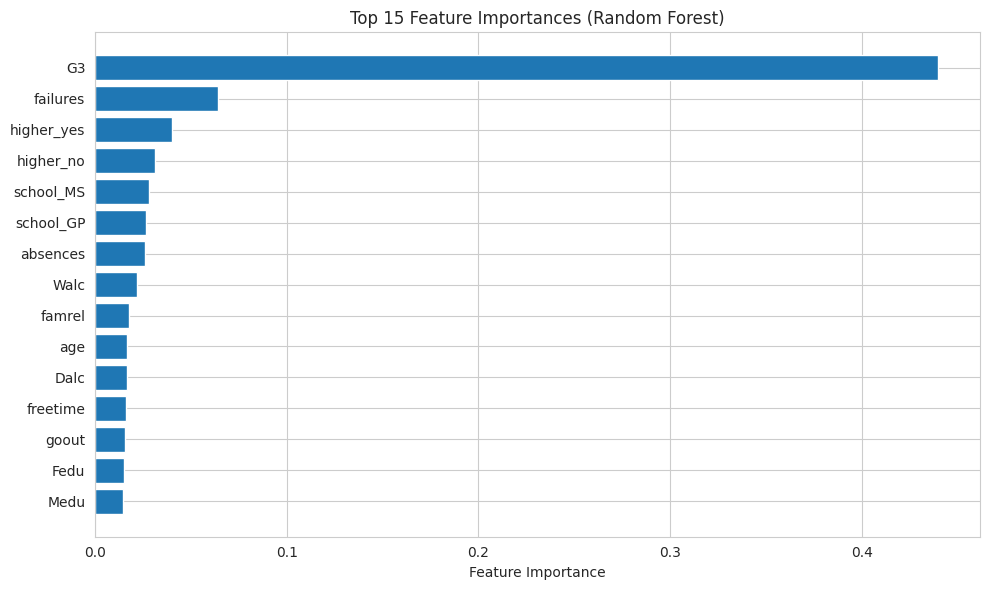

In [10]:
# Feature importances from RandomForest
import numpy as np
if 'RandomForest' in models and feature_names is not None:
    rf = models['RandomForest']
    importances = rf.feature_importances_
    idx = np.argsort(importances)[::-1]

    print('Top 20 Most Important Features:')
    print('-' * 50)
    for i, feat_idx in enumerate(idx[:20], 1):
        print(f'{i:2d}. {feature_names[feat_idx]:40s} {importances[feat_idx]:.4f}')

    # Visualize top features
    plt.figure(figsize=(10, 6))
    top_n = 15
    top_idx = idx[:top_n]
    plt.barh(range(top_n), importances[top_idx])
    plt.yticks(range(top_n), [feature_names[i] for i in top_idx])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print('Feature names not available or RandomForest not trained.')

## 5) Unsupervised Modeling
### 5.1 K-Means clustering
Cluster students and inspect cluster characteristics.

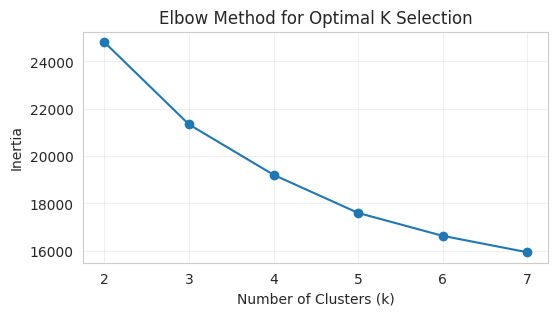

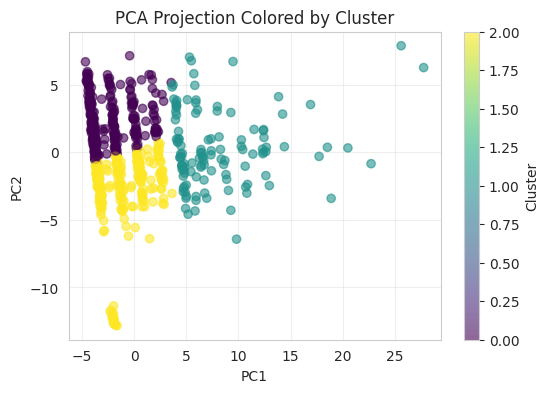


Cluster Characteristics (mean values for numeric features):


cluster,0,1,2
age,16.564460,17.220339,16.725410
Medu,2.867596,2.423729,2.143443
Fedu,2.592334,2.288136,1.979508
traveltime,1.435540,1.567797,1.725410
studytime,2.170732,1.788136,1.717213
failures,0.024390,0.372881,0.381148
famrel,4.062718,3.703390,3.885246
freetime,3.094077,3.169492,3.286885
goout,2.993031,3.491525,3.262295
Dalc,1.268293,1.898305,1.586066



Cluster Sizes:


,count
cluster,
0,287
1,118
2,244



Most Common Categorical Values per Cluster:

school:


,school
cluster,
0,GP
1,GP
2,MS



sex:


,sex
cluster,
0,F
1,F
2,F



address:


,address
cluster,
0,U
1,U
2,U



famsize:


,famsize
cluster,
0,GT3
1,GT3
2,GT3



Pstatus:


,Pstatus
cluster,
0,T
1,T
2,T


In [11]:
# KMeans clustering on preprocessed features (use PCA to reduce dimensionality for visualization)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# For unsupervised learning, fit preprocessor on full dataset (no data leakage concerns)
preproc_unsup = ColumnTransformer([('num', num_pipe, num_cols),
                                   ('cat', cat_pipe, cat_cols)], remainder='drop')
X_full_pre = preproc_unsup.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_full_pre)

# Choose k with simple elbow method
inertia = []
K = range(2,8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_full_pre)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,3))
plt.plot(list(K), inertia, marker='o')
plt.title('Elbow Method for Optimal K Selection')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)
plt.show()

# Fit k=3 as example (adjust based on elbow plot)
k = 3
km = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = km.fit_predict(X_full_pre)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('PCA Projection Colored by Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

# Attach cluster labels back to original DataFrame (first N rows aligned)
df_clustered = X.copy()
df_clustered = df_clustered.reset_index(drop=True)
df_clustered['cluster'] = clusters
df_clustered['pca1'] = X_pca[:,0]
df_clustered['pca2'] = X_pca[:,1]

# Show cluster characteristics (numeric columns only)
print('\nCluster Characteristics (mean values for numeric features):')
numeric_cols_clustered = df_clustered.select_dtypes(include=[np.number]).columns.tolist()
display(df_clustered.groupby('cluster')[numeric_cols_clustered].mean().T)

# Show cluster sizes
print('\nCluster Sizes:')
cluster_counts = df_clustered['cluster'].value_counts().sort_index()
display(cluster_counts)

# For categorical columns, show most common value per cluster
print('\nMost Common Categorical Values per Cluster:')
cat_cols_clustered = df_clustered.select_dtypes(include=['object', 'category']).columns.tolist()
if len(cat_cols_clustered) > 0:
    for col in cat_cols_clustered[:5]:  # Show first 5 categorical columns
        print(f'\n{col}:')
        display(df_clustered.groupby('cluster')[col].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else None))

### 5.2 Association Rule Mining
Find frequent itemsets and association rules from categorical features using mlxtend.

In [12]:
# Association rules using mlxtend
# Uncomment to install: !pip install mlxtend

try:
    from mlxtend.preprocessing import TransactionEncoder
    from mlxtend.frequent_patterns import apriori, association_rules

    # Prepare transactions: take categorical columns and treat each row as a transaction of 'col=value'
    cat_for_rules = cat_cols[:8] if len(cat_cols) >= 1 else []
    transactions = []

    if len(cat_for_rules) > 0:
        for _, row in df[cat_for_rules].iterrows():
            # Only include non-null values
            tx = [f'{col}={row[col]}' for col in cat_for_rules if pd.notna(row[col])]
            transactions.append(tx)

        te = TransactionEncoder()
        te_ary = te.fit(transactions).transform(transactions)
        df_tf = pd.DataFrame(te_ary, columns=te.columns_)

        # Find frequent itemsets
        freq = apriori(df_tf, min_support=0.05, use_colnames=True)

        if len(freq) > 0:
            print('Top 20 Frequent Itemsets:')
            display(freq.sort_values('support', ascending=False).head(20))

            # Generate association rules
            if len(freq) > 1:
                rules = association_rules(freq, metric='lift', min_threshold=1.2)
                if len(rules) > 0:
                    print('\nTop 20 Association Rules by Lift:')
                    display(rules.sort_values('lift', ascending=False).head(20))
                else:
                    print('No association rules found with the given threshold.')
            else:
                print('Not enough frequent itemsets to generate rules.')
        else:
            print('No frequent itemsets found with min_support=0.05')
    else:
        print('Not enough categorical columns for association rules.')

except ImportError:
    print('mlxtend not installed. Run: pip install mlxtend')
except Exception as e:
    print(f'Error in association rule mining: {e}')

Top 20 Frequent Itemsets:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,support,itemsets
10,0.876733,(Pstatus=T)
13,0.704160,(famsize=GT3)
12,0.696456,(address=U)
104,0.653313,"(Pstatus=T, famsize=GT3)"
19,0.651772,(school=GP)
103,0.596302,"(Pstatus=T, address=U)"
21,0.590139,(sex=F)
110,0.567026,"(Pstatus=T, school=GP)"
1,0.565485,(Fjob=other)
128,0.531587,"(school=GP, address=U)"



Top 20 Association Rules by Lift:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
85,"(Fjob=other, famsize=LE3)",(Pstatus=A),0.171032,0.123267,0.055470,0.324324,2.631081,1.0,0.034387,1.297565,0.747831,0.232258,0.229326,0.387162
88,(Pstatus=A),"(Fjob=other, famsize=LE3)",0.123267,0.171032,0.055470,0.450000,2.631081,1.0,0.034387,1.507214,0.707088,0.232258,0.336524,0.387162
3616,"(school=MS, Pstatus=T, Fjob=other)","(address=R, sex=F, famsize=GT3)",0.157165,0.138675,0.057011,0.362745,2.615795,1.0,0.035216,1.351618,0.732892,0.238710,0.260146,0.386928
3605,"(address=R, sex=F, famsize=GT3)","(school=MS, Pstatus=T, Fjob=other)",0.138675,0.157165,0.057011,0.411111,2.615795,1.0,0.035216,1.431229,0.717159,0.238710,0.301300,0.386928
3602,"(address=R, sex=F, Pstatus=T)","(school=MS, famsize=GT3, Fjob=other)",0.167951,0.130971,0.057011,0.339450,2.591797,1.0,0.035014,1.315614,0.738138,0.235669,0.239898,0.387372
3619,"(school=MS, famsize=GT3, Fjob=other)","(address=R, sex=F, Pstatus=T)",0.130971,0.167951,0.057011,0.435294,2.591797,1.0,0.035014,1.473421,0.706728,0.235669,0.321307,0.387372
1702,"(school=MS, Pstatus=T, Fjob=other)","(Mjob=other, address=R)",0.157165,0.129430,0.052388,0.333333,2.575397,1.0,0.032046,1.305855,0.725777,0.223684,0.234218,0.369048
1711,"(Mjob=other, address=R)","(school=MS, Pstatus=T, Fjob=other)",0.129430,0.157165,0.052388,0.404762,2.575397,1.0,0.032046,1.415963,0.702655,0.223684,0.293767,0.369048
2257,"(address=R, sex=F)","(school=MS, Pstatus=T, Fjob=other)",0.184900,0.157165,0.073960,0.400000,2.545098,1.0,0.044900,1.404725,0.744802,0.275862,0.288117,0.435294
2254,"(school=MS, Pstatus=T, Fjob=other)","(address=R, sex=F)",0.157165,0.184900,0.073960,0.470588,2.545098,1.0,0.044900,1.539634,0.720293,0.275862,0.350495,0.435294


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 6) Visualizations & Reporting
Create concise, publication-ready visuals for the report and slides.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

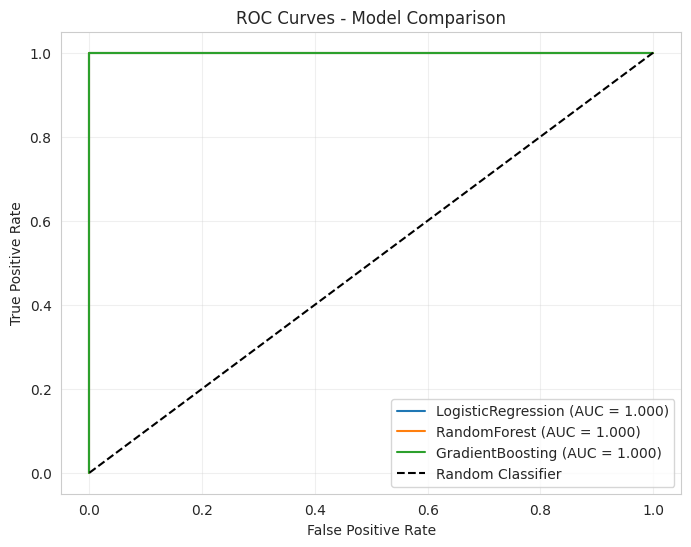

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


Confusion Matrix for Best Model: LogisticRegression


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


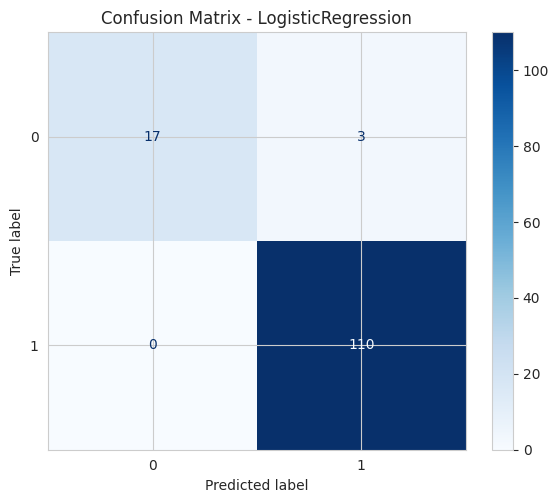

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [13]:
# Visualizations: ROC curves and Confusion Matrix
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

if y is not None and len(results) > 0:
    # Plot ROC curves for all models
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test_pre)[:,1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

    plt.plot([0,1], [0,1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Model Comparison')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Find best model by ROC AUC
    best_model_name = None
    best_auc = -1
    for name, res in results.items():
        if 'roc_auc' in res and res['roc_auc'] > best_auc:
            best_auc = res['roc_auc']
            best_model_name = name

    # Plot confusion matrix for best model
    if best_model_name:
        print(f'\nConfusion Matrix for Best Model: {best_model_name}')
        model = models[best_model_name]
        y_pred = model.predict(X_test_pre)

        fig, ax = plt.subplots(figsize=(6, 5))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
        plt.title(f'Confusion Matrix - {best_model_name}')
        plt.tight_layout()
        plt.show()
else:
    print('No models trained to visualize.')